In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from modules.loader import ImmothepDataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

loader = ImmothepDataLoader()

DATASET_PATH = '../datas/CURATED/'

%load_ext autoreload
%autoreload 2

In [2]:
loader.ensure_data_loaded()

Les fichiers sont correctement téléchargés


In [3]:
extrait_df_valeurs_foncieres = pd.read_csv(DATASET_PATH + "maison_filtre.csv", sep=',', usecols=['Valeur fonciere', 'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain', 'Code postal'], encoding='utf-8')

In [4]:
#extrait_df_valeurs_foncieres.append(resultat)
extrait_df_valeurs_foncieres = extrait_df_valeurs_foncieres.append({'Valeur fonciere' : 200000, 'Surface reelle bati' : 80, 'Nombre pieces principales' : 11, 'Surface terrain' : 648 , 'Code postal' : 36230} , ignore_index=True)

In [378]:
extrait_df_valeurs_foncieres.tail()

,Valeur fonciere,Code postal,Surface reelle bati,Nombre pieces principales,Surface terrain
263499,159000.0,97430.0,108.0,4.0,249.0
263500,360000.0,97414.0,84.0,5.0,507.0
263501,85600.0,97421.0,87.0,6.0,210.0
263502,200000.0,36230.0,80.0,4.0,648.0
263503,200000.0,36230.0,80.0,11.0,648.0


In [5]:
df_villes_france = pd.read_csv(DATASET_PATH + "villes_france.csv", sep=',', encoding='utf-8')
df_villes_france.to_csv(DATASET_PATH + "villes_france_titres.csv", header=['ville_id', 'ville_departement', 'ville_slug', 'ville_nom', 'ville_nom_simple', 'ville_nom_reel', 'ville_nom_soundex', 'ville_nom_metaphone', 'ville_code_postal', 'ville_commune', 'ville_code_commune', 'ville_arrondissement', 'ville_canton', 'ville_amdi', 'ville_population_2010', 'ville_population_1999', 'ville_population_2012', 'ville_densite_2010', 'ville_surface', 'ville_longitude_deg', 'ville_latitude_deg', 'ville_longitude_grd', 'ville_latitude_grd', 'ville_longitude_dms', 'ville_latitude_dms', 'ville_zmin', 'ville_zmax'], index=False)

df_villes_france_titres_vue = pd.read_csv(DATASET_PATH + "villes_france_titres.csv", sep=',', usecols=['ville_code_postal', 'ville_nom_reel', 'ville_population_2012', 'ville_surface'], encoding='utf-8')

df_villes_france_titres = pd.read_csv(DATASET_PATH + "villes_france_titres.csv", sep=',', usecols=['ville_code_postal', 'ville_nom_soundex', 'ville_population_2012', 'ville_surface'], encoding='utf-8')

#test_df_valeurs_foncieres.writerow(['Département', 'Slug', 'Nom', 'Nom simple', 'Nom Reel', 'Nom soundex', 'Nom metaphone', 'Code postal', 'Numéro de commune', 'Code commune', 'Arrondissement', 'Canton', 'Population en 2010', 'Population en 1999', 'Population en 2012', 'Densité en 2010', 'Surface / superficie', 'Longitude/latitude en degré', 'Longitude/latitude en GRD', 'Longitude/latitude en DMS', 'Altitude minimale/maximale'])

#test_df_valeurs_foncieres = pd.read_csv(DATASET_PATH + "villes_france.csv", sep=',', names=['Département', 'Slug', 'Nom', 'Nom simple', 'Nom Reel', 'Nom soundex', 'Nom metaphone', 'Code postal', 'Numéro de commune', 'Code commune', 'Arrondissement', 'Canton', 'Population en 2010', 'Population en 1999', 'Population en 2012', 'Densité en 2010', 'Surface / superficie', 'Longitude/latitude en degré', 'Longitude/latitude en GRD', 'Longitude/latitude en DMS', 'Altitude minimale/maximale'], header=None), usecols=['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain', 'Code postal'], encoding='utf-8')

 #user1 = pd.read_csv('dataset/1.csv', names=['TIME', 'X', 'Y', 'Z'], header=None)

In [6]:
df_villes_france_titres['code_postal'] = df_villes_france_titres['ville_code_postal'].str[:5]
df_villes_france_titres = df_villes_france_titres.drop('ville_code_postal', 1)

In [34]:
df_villes_france_titres["code_postal"] = df_villes_france_titres["code_postal"].astype(float)
extrait_df_valeurs_foncieres["Code postal"] = extrait_df_valeurs_foncieres["Code postal"].astype(float)

df_Test = pd.merge(df_villes_france_titres, extrait_df_valeurs_foncieres, left_on='code_postal', right_on='Code postal')
df_Test2 = df_Test.groupby('code_postal').mean()
df_Test2['ville_surface'] = df_Test2['ville_surface'] * 1000
#df_Test2['rapport_population_surface'] = df_Test2['ville_population_2012'] / df_Test2['ville_surface']
#df_Test2['facteur_valeur_fonciere'] = (df_Test2['Surface reelle bati'] / (df_Test2['Nombre pieces principales'] / df_Test2['Surface terrain'])) * (df_Test2['ville_population_2012'] / df_Test2['ville_surface'])

df_Test2['facteur_valeur_fonciere'] = ((df_Test2['Surface terrain'] / (df_Test2['Surface reelle bati']) * df_Test2['Nombre pieces principales'])) * ((df_Test2['ville_population_2012'] / df_Test2['ville_surface']))

#df_Test2['facteur_valeur_fonciere'] = df_Test2['Valeur fonciere'] * df_Test2['facteur_valeur_fonciere']
"""print((df_Test2['Surface terrain'] / (df_Test2['Surface reelle bati']) * df_Test2['Nombre pieces principales']))
print((df_Test2['ville_population_2012'] / df_Test2['ville_surface']))"""

print(df_Test2['Surface terrain'].mean(axis=0) / df_Test2['Surface reelle bati'].mean(axis=0))
#print(df_Test2['Nombre pieces principales'].mean(axis=0))
#print(df_Test2['ville_population_2012'].mean(axis=0))

"""df_Test2['formule_terrain'] = (df_Test2['Surface terrain'].mean(axis=0) / df_Test2['Surface reelle bati'].mean(axis=0)) - (df_Test2['Surface terrain'] / df_Test2['Surface reelle bati'])
df_Test2['formule_piece'] = 1 - (df_Test2['Nombre pieces principales'] / df_Test2['Nombre pieces principales'].mean(axis=0))
df_Test2['formule_surface'] = 1 - (df_Test2['ville_population_2012'] / df_Test2['ville_surface'])

df_Test2['formule_finale'] = df_Test2['formule_terrain'] + df_Test2['formule_piece'] + df_Test2['formule_surface']"""

formuleTerrain =  (df_Test2['Surface terrain'].mean(axis=0) / df_Test2['Surface reelle bati'].mean(axis=0)) - (df_Test2['Surface terrain'] / df_Test2['Surface reelle bati'])
formulePiece = 1 - (df_Test2['Nombre pieces principales'] / df_Test2['Nombre pieces principales'].mean(axis=0))
formuleSurface = 1 - (df_Test2['ville_population_2012'] / df_Test2['ville_surface'])

df_Test2['formule_finale'] = formuleTerrain + formulePiece + formuleSurface

df_Test2['valeur_estimee'] = df_Test2['Valeur fonciere'] * (df_Test2['formule_finale'] + 100) / 100

df_Test2.head()

#df_Test2 = df_Test2.drop('Code postal', 1)
#df_Test2 = df_Test2.drop('code_postal', 1)

5.80236397742181


,ville_population_2012,ville_surface,Valeur fonciere,Code postal,Surface reelle bati,Nombre pieces principales,Surface terrain,facteur_valeur_fonciere,formule_finale,valeur_estimee
code_postal,,,,,,,,,,
1000.0,22700.000000,18220.000000,216377.566265,1000.0,108.578313,4.566265,623.855422,32.687331,-0.249063,215838.648899
1090.0,1383.333333,6858.333333,237181.494186,1090.0,99.488372,4.162791,603.116279,5.090044,0.572263,238538.796166
1100.0,6925.000000,19387.500000,182098.062500,1100.0,101.987500,4.437500,547.275000,8.505405,1.049092,184008.439610
1110.0,710.000000,19704.000000,151324.130435,1110.0,109.021739,4.195652,734.478261,1.018519,0.055493,151408.104629
1120.0,2500.000000,13367.142857,285763.571429,1120.0,104.232143,4.357143,554.375000,4.334162,1.285349,289436.631239


In [33]:
print ((df_Test2['formule_finale'] + 100) / 100)

code_postal
1000.0     0.997509
1090.0     1.005723
1100.0     1.010491
1110.0     1.000555
1120.0     1.012853
             ...   
97450.0    1.008631
97460.0    0.986375
97470.0    1.022707
97480.0    1.002272
97490.0    1.003054
Name: formule_finale, Length: 5447, dtype: float64


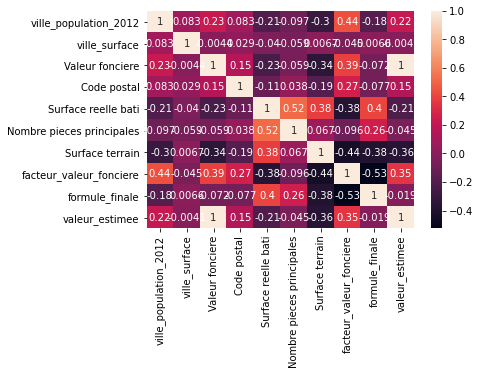

In [50]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df_Test2.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [201]:
print (df_Test2['Valeur fonciere'])
print (((df_Test2['Surface reelle bati'] / (df_Test2['Nombre pieces principales']) + df_Test2['Surface terrain']) / 2) * (df_Test2['ville_population_2012'] / df_Test2['ville_surface']) * 10000)

code_postal
1000.0     216377.566265
1090.0     237181.494186
1100.0     182098.062500
1110.0     151324.130435
1120.0     285763.571429
               ...      
97450.0    182520.714286
97460.0    243000.000000
97470.0    190137.500000
97480.0    180229.516854
97490.0    232506.250000
Name: Valeur fonciere, Length: 5447, dtype: float64
code_postal
1000.0     4.034382e+06
1090.0     6.323488e+05
1100.0     1.018449e+06
1110.0     1.370099e+05
1120.0     5.407823e+05
               ...     
97450.0    1.354711e+06
97460.0    1.267321e+06
97470.0    3.517305e+05
97480.0    6.213901e+05
97490.0    2.586555e+06
Length: 5447, dtype: float64


In [6]:
#dfFiltre = df_villes_france_titres.drop(df_villes_france_titres[df_villes_france_titres['ville_code_postal'].str.len() > 5].index)

In [8]:
"""dfFiltre["ville_code_postal"] = dfFiltre["ville_code_postal"].astype(float)
extrait_df_valeurs_foncieres["Code postal"] = extrait_df_valeurs_foncieres["Code postal"].astype(float)"""

#type(df_villes_france_titres['ville_code_postal'])

#df_test = df_villes_france_titres.merge(extrait_df_valeurs_foncieres)

#df_Test2 = df_Test.drop_duplicates('ville_nom_soundex').sort_index()

#df_Test2 = df_Test.groupby('ville_nom_soundex').mean()
"""df_Test2 = df_Test.groupby('ville_code_postal').mean()
df_Test = pd.merge(dfFiltre, extrait_df_valeurs_foncieres, left_on='ville_code_postal', right_on='Code postal')"""

NameError: name 'dfFiltre' is not defined

In [41]:
"""df_Test2['ville_surface'] = df_Test2['ville_surface'] * 1000
df_Test2 = df_Test2.drop('Code postal', 1)"""


In [6]:
"""import dload
j = dload.json('https://geo.api.gouv.fr/communes?codePostal=' + dfAjout['Code postal'].values[0])
print(j)"""

"""import json,urllib.request
data = urllib.request.urlopen('https://geo.api.gouv.fr/communes?codePostal=36230')
output = json.loads(data)
print (output)"""
print(str(dfAjout['Code postal'].values[0]))

import urllib.request, json 
with urllib.request.urlopen('https://geo.api.gouv.fr/communes?codePostal=36230') as url:
#with urllib.request.urlopen('https://geo.api.gouv.fr/communes?codePostal=36230' + str(dfAjout['Code postal'].values[0])) as url:
    data = json.loads(url.read().decode())
    print(data)

1160.0
[{'nom': 'Vatan', 'code': '36230', 'codeDepartement': '36', 'codeRegion': '24', 'codesPostaux': ['36150'], 'population': 2019}]


In [43]:
data = df_Test2.values
X = data[:, 7:]  # all rows, no label
y = data[:, 9]  # all rows, label only
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.*,test_size=0.*, random_state=*)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [384]:
print(X)
print(y)

[[1.56767932]
 [0.29373277]
 [0.43193487]
 ...
 [0.1703437 ]
 [0.31348747]
 [1.41631608]]
[216377.56626506 237181.49418605 182098.0625     ... 190137.5
 180229.51685393 232506.25      ]


In [44]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [45]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
estimator = SGDRegressor()
# estimator = LinearRegression()  # LinearRegression works with sparse matrix
estimator.fit(X_train, y_train)
predicted = estimator.predict(X_train)

In [47]:
print(predicted[-1])

357021.94984447886


In [47]:
"""import json

estimation_set = {"estimation": str(round(predicted[-1]))}
json_estimation = json.dumps(estimation_set)
print(json_estimation)"""


{"estimation": "16687"}


In [32]:
"""filtrePrediction = [ele for ele in predicted if ele > 0] 

set1 = set(predicted)
set2 = set(filtrePrediction)

missing = list(sorted(set1 - set2))"""

#dfytrain = predicted[~predicted['0'].isin(str(filtrePrediction))]

#print(predicted[0])
#filtrePrediction = predicted.drop(predicted[predicted['0'].str.len() < 0].index)

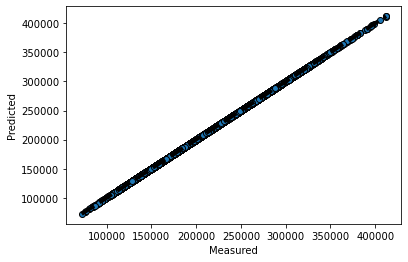

In [48]:

fig, ax = plt.subplots()
#plt.xlim(0, 200000)
#plt.ylim(0, 200000) 
ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
#ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [49]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, y_train)

y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
# model evaluation for testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)
 
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 4.6830153417842285e-11
le score R2 est 1.0


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 4.486067174240016e-11
le score R2 est 1.0
